## Import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.modeling import Fit, Parameter, Parameters, Covariance


import warnings
from my_dataset_maps_19 import MapDatasetNuisance
warnings.filterwarnings('ignore')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



## Definitions 

In [41]:
def plot_residual_comparison(dataset1, dataset2, elist, radius = 1.0*u.deg, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(len(elist)*1,3 ,figsize =(15,len(elist)*5))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        
        residual1 = dataset1.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = dataset2.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][1],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][0],
                                                        vmax = vmax_, vmin = -vmax_)
                
        estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=dataset1.counts.geom.axes['energy'].edges) 
        result1 = estimator.run(dataset1) 
        result2 = estimator.run(dataset2) 


        residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = result2["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        
        n, bins, patches = axs[i][2].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = default_colors[1], alpha = 0.5)
        axs[i][2].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = default_colors[2], alpha = 0.5)



        axs[i][2].legend(fontsize = 14)
        axs[i][2].set_xlabel('Significance'); axs[i][2].set_yscale('log')
        axs[i][1].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[i][0].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig

def plot_residual_comparison_vertical(dataset1, dataset2, elist, radius = 1.0*u.deg, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(3, len(elist)*1 ,figsize =(len(elist)*5, 15))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        residual1 = dataset1.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = dataset2.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1)))
        
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.smooth(radius).data))
        print("vmax_:", vmax_)   
        residual2.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[1][i],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.smooth(radius).plot(cmap = 'coolwarm', add_cbar = True,ax = axs[0][i],
                                                        vmax = vmax_, vmin = -vmax_)
        cbar = axs[0][i].images[-1].colorbar 
        cbar.set_label("Significance", rotation = 90)
        cbar = axs[1][i].images[-1].colorbar 
        cbar.set_label("Significance", rotation = 90)
        
        
        estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=dataset1.counts.geom.axes['energy'].edges) 
        result1 = estimator.run(dataset1) 
        result2 = estimator.run(dataset2) 


        residual1 = result1["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        residual2 = result2["sqrt_ts"].slice_by_idx(dict(energy=slice(e,e+1)))
        
        n, bins, patches = axs[2][i].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = default_colors[1], alpha = 0.5)
        axs[2][i].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = default_colors[2], alpha = 0.5)



        axs[2][i].legend(fontsize = 14)
        axs[2][i].set_xlabel('Significance'); axs[2][i].set_yscale('log')
        axs[1][i].set_title('With Nui Par; \nSmoothing Radius:'+str(radius), fontsize = 14)
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[0][i].set_title(ee ,fontsize = 14)
        

    plt.tight_layout()
    return fig




## Import of Datasets

In [3]:
source = "Crab"

In [4]:
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
# here the dataset with the fine binning is saved
#dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
# This is for now the binning of 0.08 deg
dataset_standard = MapDataset.read(f'{source}/stacked.fits')

models = Models.read(f'{source}/standard_model.yml')

with open(f'{source}/standard_bgmodel.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
print(best_fit_bgmodel)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']


models.append(bkg_model)
dataset_standard.models = models
dataset_standard.geoms['geom']

{'datasets_names': ['zqKn9jMc'], 'spectral': {'parameters': [{'error': 0.0016224536231473417, 'name': 'norm', 'value': 0.9965459485124857}, {'frozen': True, 'name': 'tilt', 'value': 0.0}, {'frozen': True, 'name': 'reference', 'unit': 'TeV', 'value': 1.0}], 'type': 'PowerLawNormSpectralModel'}, 'type': 'FoVBackgroundModel'}


WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (150, 150, 24)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 12.0 deg x 12.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

In [5]:
added = '_008_624'
ebins = range(6,20)


pathsource = f"{source}/"
dataset_N_10 = MapDatasetNuisance.read(f"{path}/{pathsource}nui_dataset{added}.fits")
with open(f'{pathsource}nui_par{added}.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
with open(f'{pathsource}nui_model{added}.yml', "r") as ymlfile:
    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(f'{pathsource}nui_bgmodel{added}.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
models = Models.from_dict(best_fit_model )
models.append(bkg_model)
dataset_N_10.models =models
dataset_N_10.geoms['geom']

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (150, 150, 24)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 12.0 deg x 12.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

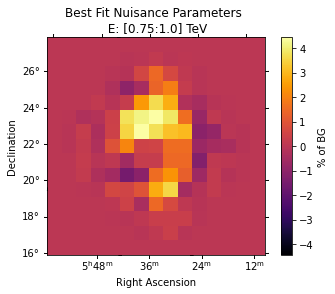

In [6]:
N_map = dataset_N_10.N_map().slice_by_idx(dict(energy=slice(7,8)))
N_map.data *=100
vmax = np.nanmax(np.abs(N_map.data))
N_map.plot(
    add_cbar = True, vmax =vmax, vmin = -vmax, cmap = 'inferno');
ax = plt.gca()
fig= plt.gcf()
cbar = plt.gca().images[-1].colorbar
cbar.set_label('% of BG', rotation=90)
ax.set_title(f'Best Fit Nuisance Parameters \n E: [{0.75}:{1.0}] TeV', )
name = f'{source}/plots/N_parameters.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

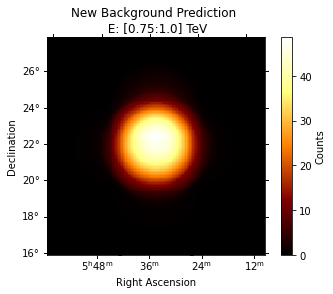

In [7]:
bg = dataset_N_10.npred_background().slice_by_idx(dict(energy=slice(7,8)))
vmax = np.nanmax(np.abs(bg.data))
bg.plot(
    add_cbar = True, );
ax = plt.gca()
fig= plt.gcf()
cbar = plt.gca().images[-1].colorbar
cbar.set_label('Counts', rotation=90)
ax.set_title(f'New Background Prediction \n E: [{0.75}:{1.0}] TeV', )
name = f'{source}/plots/BG_prediction.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

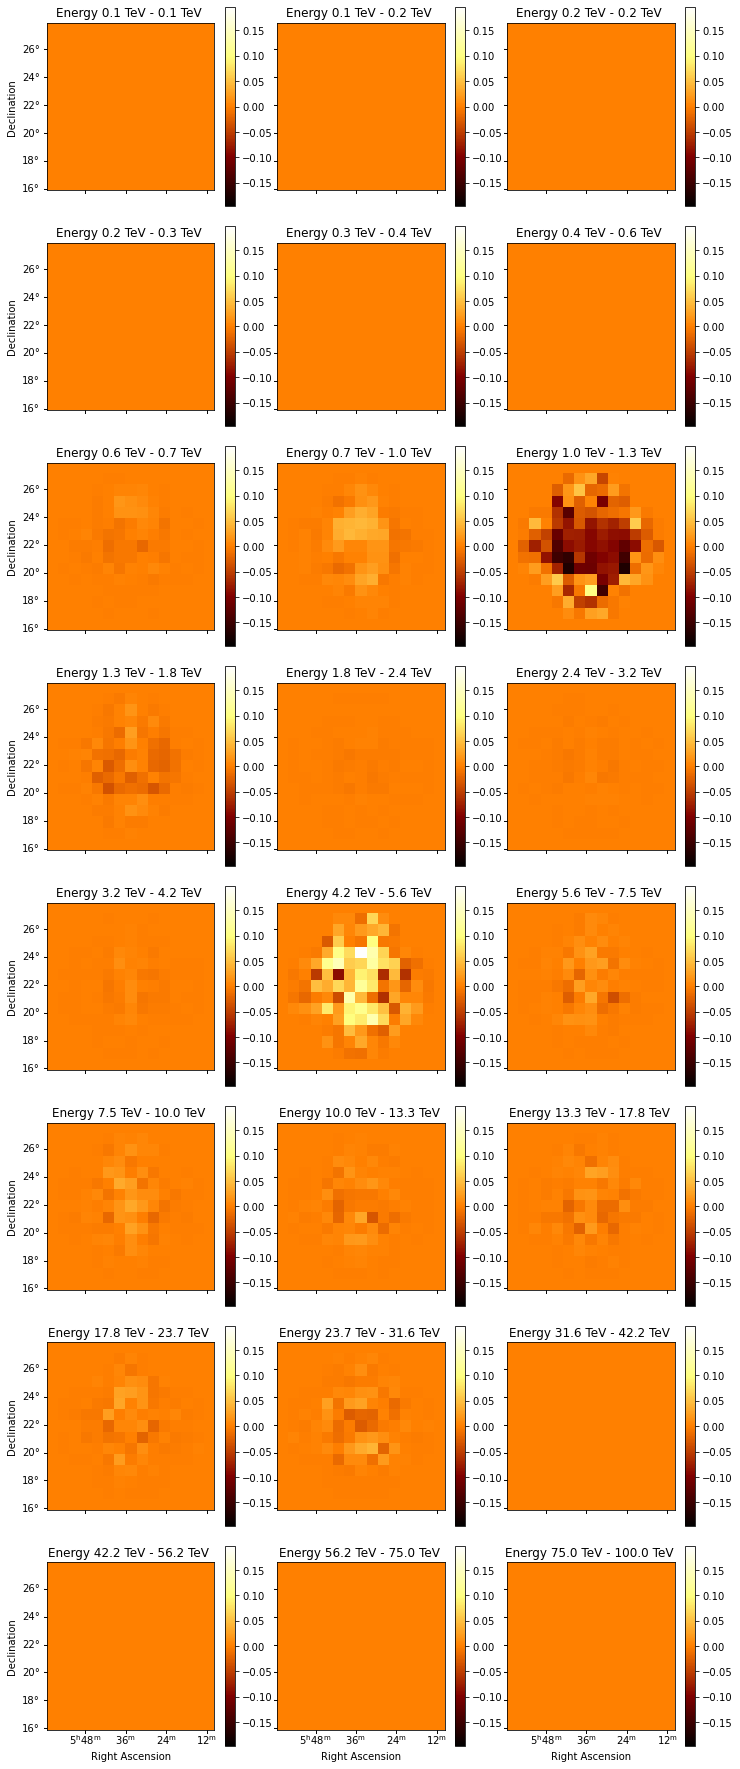

In [8]:
vmax = np.nanmax(np.abs(dataset_N_10.N_map().data))
dataset_N_10.N_map().plot_grid(add_cbar = True, vmax =vmax, vmin = -vmax);

1.2308969170301811


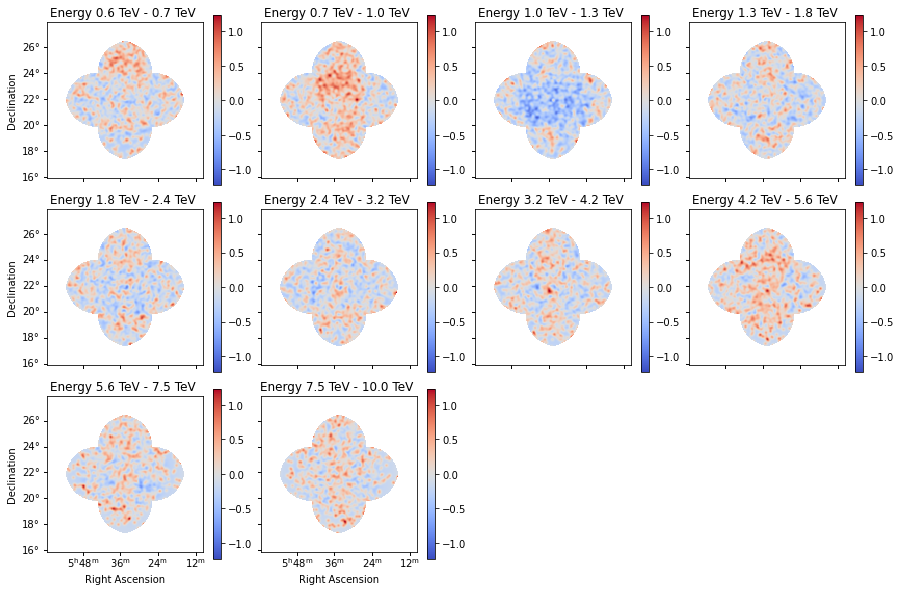

In [9]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(np.nan_to_num(res_standard.data)))
print(vmax)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm", ncols=4,figsize = (15,10));

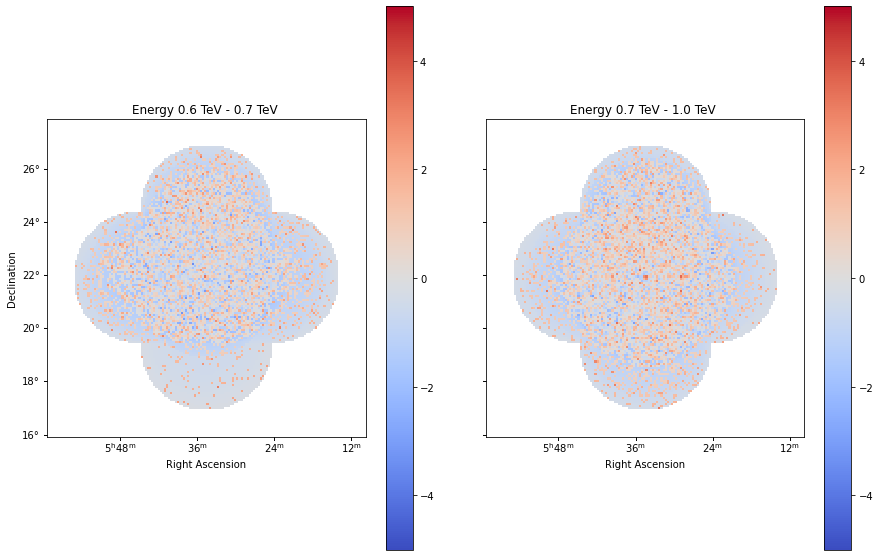

In [10]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.07 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[6:9])
result = estimator.run(dataset_standard)
ax = result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,ncols=4,figsize = (15,10));

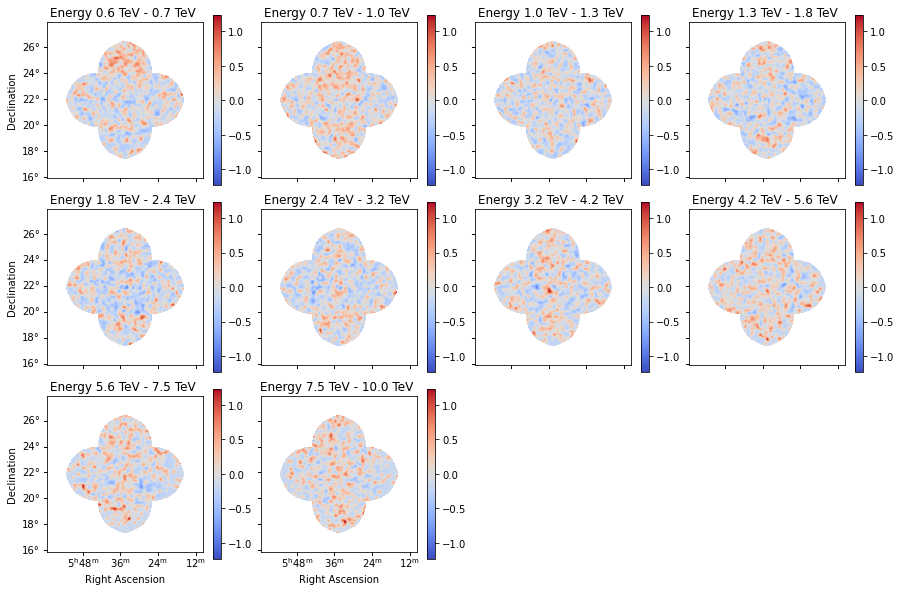

In [11]:
res_nui = (
    dataset_N_10.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
res_nui.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm", ncols=4,figsize = (15,10));

## Comparison of the Spatial Resiudal Maps

In [13]:
dataset_N_10_pseudo = dataset_standard.copy()
dataset_N_10_pseudo.models = dataset_N_10.models.copy()
dataset_N_10_pseudo.background = dataset_N_10.npred_background()

Radius: 0.1 deg
7
residual1.data: 8.739826550145247
vmax_: 1.2308969170301811


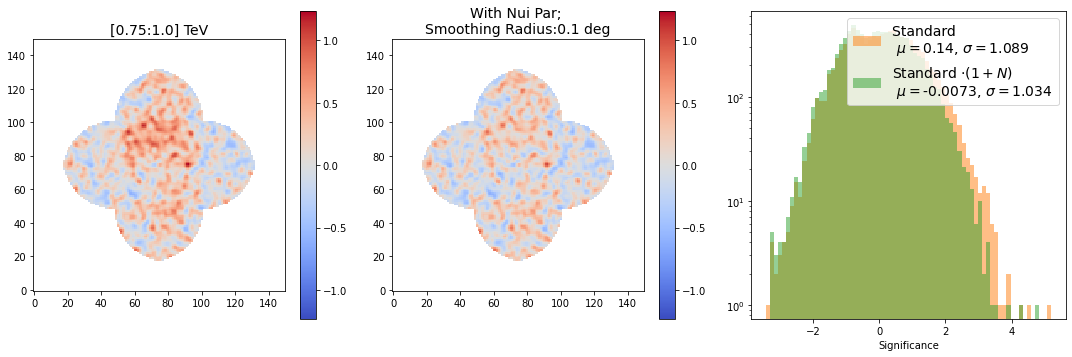

In [36]:
fig = plot_residual_comparison(dataset_standard, dataset_N_10_pseudo,[7] , radius = 0.1*u.deg )

Radius: 0.07 deg
6
residual1.data: 7.38039049350974
vmax_: 1.4901939514195353
7
residual1.data: 8.739826550145247
vmax_: 1.7337438382465575
8
residual1.data: 8.256677969550246
vmax_: 1.8068738828675048
9
residual1.data: 7.650240035606463
vmax_: 1.5027796915742575


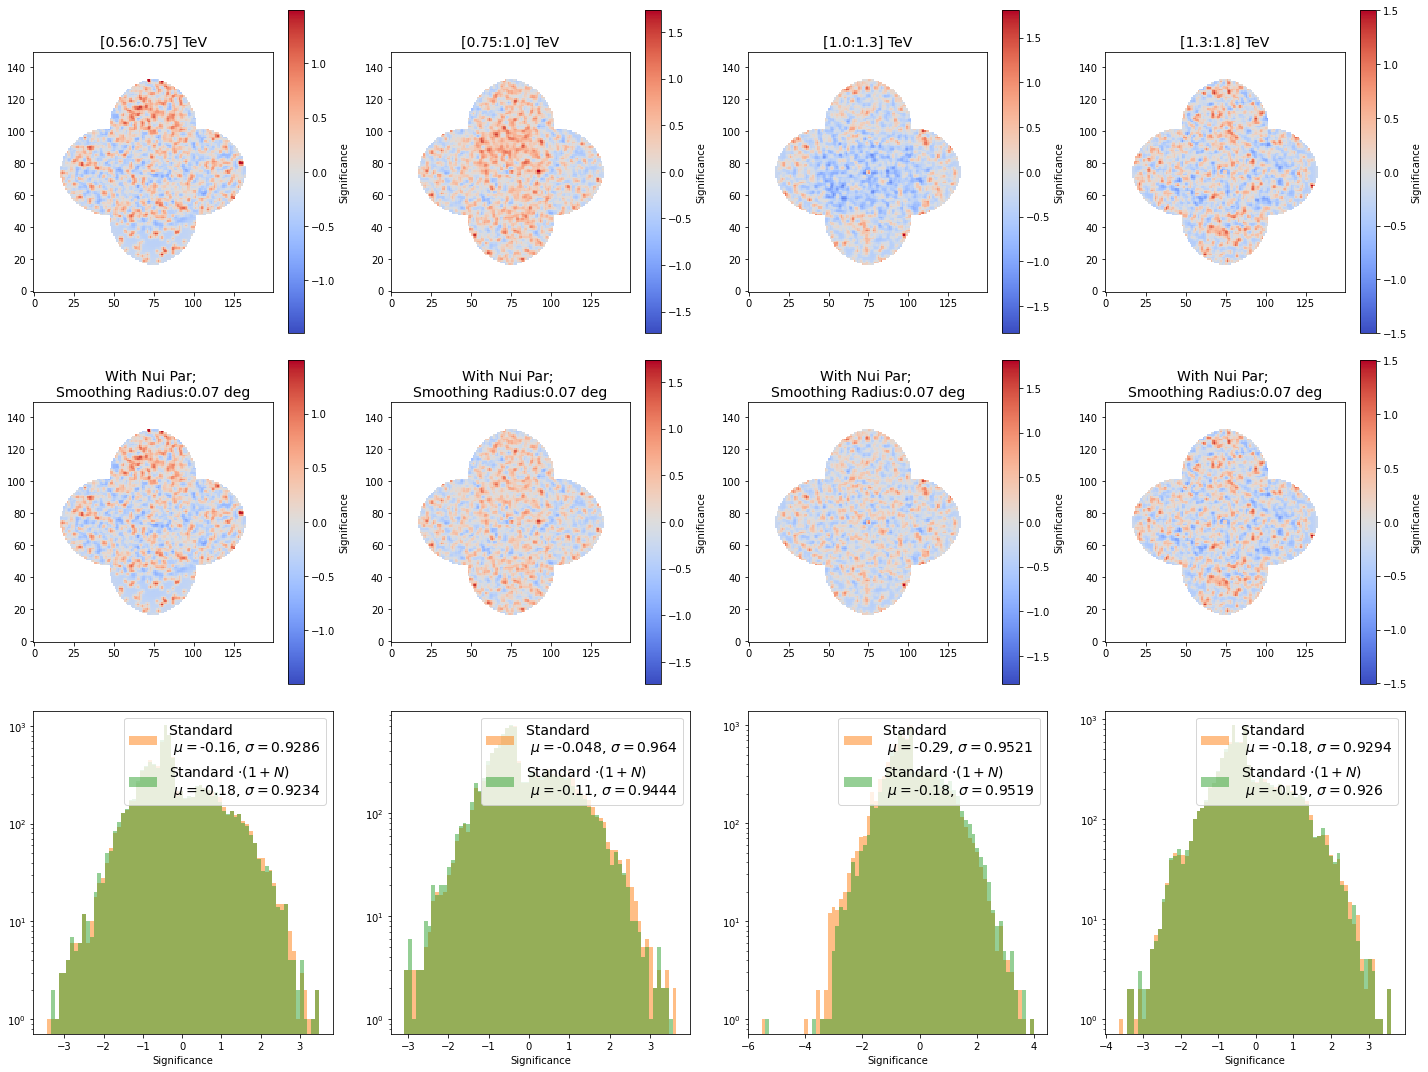

In [43]:

fig = plot_residual_comparison_vertical(dataset_standard, dataset_N_10_pseudo,[6,7,8,9] , radius = 0.07*u.deg)
name = f'{source}/plots/Sigmaps.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

In [ ]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

In [ ]:
dataset_N.plot_residuals(kwargs_spectral=kwargs_spectral);

## Comparison of the Best Fit Model Parameters

In [ ]:
print(" with nuisance")
print("(without nuisance)")
for p_N, p_stand in zip(dataset_N_10.models.parameters.free_parameters,
                        dataset_standard.models.parameters.free_parameters ):
    print()
    print('='*5)
    print(p_N.name, p_stand.name)
    print('-'*5)
    print(' {:.4}  pm {:.3}'.format(p_N.value, float(p_N.error)) )    
    print('({:.4}  pm {:.3})'.format(p_stand.value, float(p_stand.error)) )

print("nuisance: {:.4} std: {:.4}".format(np.mean(dataset_N_10.N_parameters.value)
                                   , np.std(dataset_N_10.N_parameters.value)))

In [ ]:
sysamplitude_percentage = np.loadtxt((f'{path}/{source}/sysamplitude_percentage.txt'))
# Convert to %:
sysamplitude_percentage /= 100


In [ ]:
len(default_colors*2)
default_colors = default_colors * 2

In [ ]:
ebins = range(6,24)
fig = plt.figure(figsize = (15,7))
eaxis = dataset_N_10.geoms['geom'].axes[0].center.value
amount = dataset_N_10.geoms['geom_down'].data_shape[1]**2
mean_N_pars = []
max_N_pars = []
min_N_pars = []

bg_eaxis = dataset_N_10.background.data.sum(axis=2).sum(axis=1)
bg_down = dataset_N_10.background#.downsample(10,preserve_counts=True) 
bg_down_npred = dataset_N_10.npred_background()#.downsample(10,preserve_counts=True) 


for i, e in enumerate(ebins):
    print(i,e)
    data = ((bg_down_npred -bg_down  )/bg_down_npred).data[e,:,:].flatten()
    Ns = [d if np.abs(d)>0 else np.nan for d in data ]
    for N in Ns:
        plt.scatter(eaxis[e], [N], color = default_colors[i], s=10)
    plt.errorbar(x =eaxis[e]*1.1, y =  np.nanmean(Ns), yerr = np.nanstd(Ns), fmt='x')
plt.plot(eaxis,sysamplitude_percentage, label = "Expected Systematic") # * bg_eaxis
plt.ylabel('Systematic [% BG]')
plt.xlabel('Energy [TeV]')
plt.xscale('log')